<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 1 - 3/3: Exploration et analyse des données EDA** </span> </font> 

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Dans ce notebook, nous allons ...

# Importation des données et des librairies Python pour DS

In [2]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import re
import gc
import time
import missingno as msno #missing data visualizations
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 800)

In [7]:
#num_rows = None  # 10000
train_df = pd.read_csv('data/traited/df_train_corr_import_small.csv')  # , nrows=num_rows

In [8]:
train_df.head()

,EXT_SOURCE_1,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,AMT_ANNUITY,INSTAL_DPD_MEAN,PREV_CNT_PAYMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,ACTIVE_DAYS_CREDIT_MAX,OWN_CAR_AGE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,AMT_CREDIT,POS_MONTHS_BALANCE_SIZE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,DAYS_ID_PUBLISH,BURO_DAYS_CREDIT_ENDDATE_MAX,ANNUITY_INCOME_PERC,INSTAL_DBD_SUM,DAYS_LAST_PHONE_CHANGE,INSTAL_PAYMENT_PERC_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CLOSED_DAYS_CREDIT_MAX,CODE_GENDER,INSTAL_PAYMENT_DIFF_MEAN,DAYS_REGISTRATION,INSTAL_AMT_PAYMENT_MIN,PREV_APP_CREDIT_PERC_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,INSTAL_AMT_INSTALMENT_MAX,PREV_AMT_ANNUITY_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,REGION_POPULATION_RELATIVE,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MAX,INCOME_CREDIT_PERC,PREV_DAYS_DECISION_MIN,PREV_APP_CREDIT_PERC_MIN,APPROVED_DAYS_DECISION_MAX,PREV_AMT_DOWN_PAYMENT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,POS_MONTHS_BALANCE_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,BURO_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,CLOSED_AMT_CREDIT_SUM_MEAN,PREV_DAYS_DECISION_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,PREV_AMT_ANNUITY_MIN,ACTIVE_AMT_CREDIT_SUM_MAX,BURO_DAYS_CREDIT_MAX,BURO_AMT_CREDIT_SUM_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_APP_CREDIT_PERC_VAR,INSTAL_DBD_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,APARTMENTS_AVG,PREV_AMT_ANNUITY_MAX,BURO_DAYS_CREDIT_VAR,INSTAL_AMT_INSTALMENT_MEAN,CC_AMT_BALANCE_MEAN,POS_SK_DPD_DEF_MAX,APPROVED_AMT_APPLICATION_MAX,ACTIVE_DAYS_CREDIT_MEAN,POS_MONTHS_BALANCE_MAX,APPROVED_CNT_PAYMENT_SUM,POS_NAME_CONTRACT_STATUS_Active_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_DAYS_DECISION_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,INSTAL_DBD_MAX,PREV_NAME_YIELD_GROUP_high_MEAN,LANDAREA_AVG,INSTAL_PAYMENT_DIFF_SUM,CC_CNT_DRAWINGS_CURRENT_MEAN,ACTIVE_AMT_CREDIT_SUM_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,YEARS_BEGINEXPLUATATION_AVG,BASEMENTAREA_AVG,BURO_STATUS_0_MEAN_MEAN,BURO_DAYS_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MAX,CLOSED_AMT_CREDIT_SUM_MAX,NAME_FAMILY_STATUS_Married,BURO_CREDIT_TYPE_Microloan_MEAN,APPROVED_APP_CREDIT_PERC_VAR,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_DOWN_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INCOME_PER_PERSON,BURO_CREDIT_TYPE_Mortgage_MEAN,PREV_AMT_GOODS_PRICE_MIN,NAME_CONTRACT_TYPE_Cashloans,NAME_EDUCATION_TYPE_Highereducation,CLOSED_DAYS_CREDIT_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,BURO_AMT_CREDIT_SUM_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,REFUSED_DAYS_DECISION_MAX,REGION_RATING_CLIENT,CC_AMT_BALANCE_VAR,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_DAYS_CREDIT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,NONLIVINGAREA_AVG,YEARS_BUILD_AVG,POS_NAME_CONTRACT_STATUS_Completed_MEAN,REFUSED_AMT_APPLICATION_MIN,INSTAL_PAYMENT_DIFF_MAX,PREV_AMT_APPLICATION_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,FLAG_DOCUMENT_3,PREV_PRODUCT_COMBINATION_CashStreetlow_MEAN,BURO_STATUS_X_MEAN_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,APPROVED_AMT_APPLICATION_MIN,PREV_CHANNEL_TYPE_Creditandcashoffices_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_DAYS_CREDIT_VAR,BURO_CREDIT_TYPE_Carloan_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,ACTIVE_DAYS_CREDIT_MIN,PREV_AMT_APPLICATION_MAX,BURO_STATUS_1_MEAN_MEAN,REFUSED_DAYS_DECISION_MIN,PREV_NAME_TYPE_SUITE_nan_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,INSTAL_PAYMENT_PERC_VAR,PREV_NAME_YIELD_GROUP_low_normal_MEAN,COMMONAREA_AVG,REFUSED_AMT_ANNUITY_MIN,INSTAL_DPD_SUM,PREV_CNT_PAYMENT_SUM,AMT_INCOME_TOTAL,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,DEF_60_CNT_SOCIAL_CIRCLE,BURO_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,BURO_STATUS_C_MEAN_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,REFUSED_APP_CREDIT_PERC_MIN,HOUR_APPR_PROCESS_START,CC_AMT_DRAWINGS_CURRENT_VAR,AMT_REQ_CREDIT_BUREAU_QRT,PREV_PRODUCT_COMB

In [9]:
train_df.shape

(307507, 250)

# Correlation avec la variable target

In [16]:
# Calculate all correlations in dataframe
corrs = train_df.corr()

In [23]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
positif_corr = pd.DataFrame(corrs['TARGET'].head(11)).iloc[1:,:]
positif_corr

,TARGET
CC_CNT_DRAWINGS_CURRENT_MAX,0.101389
BURO_DAYS_CREDIT_MEAN,0.089731
CC_AMT_BALANCE_MEAN,0.087177
CC_CNT_DRAWINGS_CURRENT_MEAN,0.082520
DAYS_BIRTH,0.078242
PREV_NAME_CONTRACT_STATUS_Refused_MEAN,0.077681
BURO_CREDIT_ACTIVE_Active_MEAN,0.077356
BURO_DAYS_CREDIT_MIN,0.075248
DAYS_EMPLOYED,0.074957
BURO_DAYS_CREDIT_UPDATE_MEAN,0.068929


In [24]:
# Ten most negative correlations
negatif_corr = pd.DataFrame(corrs['TARGET'].tail(10))
negatif_corr

,TARGET
CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,-0.045460
REFUSED_HOUR_APPR_PROCESS_START_MIN,-0.051747
CODE_GENDER,-0.054710
BURO_STATUS_C_MEAN_MEAN,-0.055936
NAME_EDUCATION_TYPE_Highereducation,-0.056593
PREV_NAME_CONTRACT_STATUS_Approved_MEAN,-0.063526
BURO_MONTHS_BALANCE_SIZE_MEAN,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160471
EXT_SOURCE_3,-0.178926


La variable la plus corrélée avec la variable cible, est une variable que nous avons créée. Cependant, le simple fait qu'une variable soit corrélée ne signifie pas qu'elle sera utile, et nous devons nous rappeler que si nous générons des centaines de nouvelles variables, certaines seront corrélées avec la variable cible simplement en raison de bruit aléatoire.

# Relation Target/Variables

In [21]:
train_df['TARGET'].value_counts(normalize=True)

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64

In [22]:
positive_df = train_df[train_df['TARGET']==1]
negative_df = train_df[train_df['TARGET']==0]

In [32]:
columns = train_df.drop(columns = ["TARGET"]).columns

Index(['EXT_SOURCE_1', 'PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'APPROVED_CNT_PAYMENT_MEAN',
       'AMT_ANNUITY', 'INSTAL_DPD_MEAN', 'PREV_CNT_PAYMENT_MEAN',
       ...
       'REFUSED_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MEAN',
       'PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN',
       'FLAG_DOCUMENT_16', 'PREV_CODE_REJECT_REASON_LIMIT_MEAN',
       'CC_AMT_CREDIT_LIMIT_ACTUAL_MIN', 'CC_AMT_DRAWINGS_CURRENT_SUM',
       'PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN',
       'PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN', 'SK_ID_CURR'],
      dtype='object', length=249)

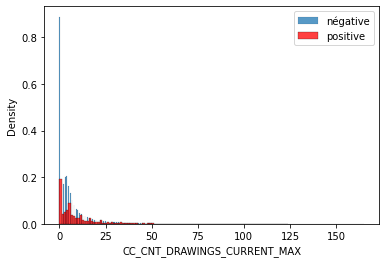

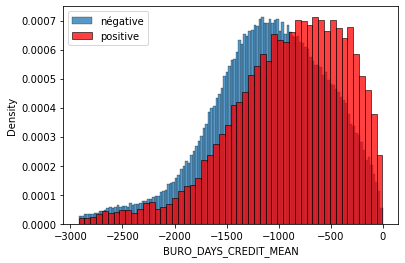

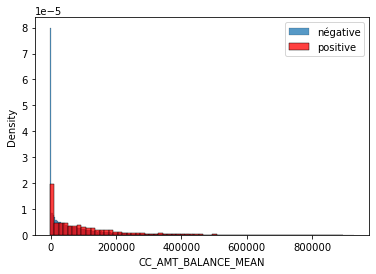

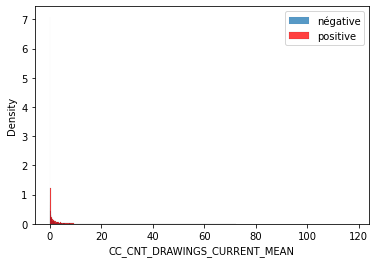

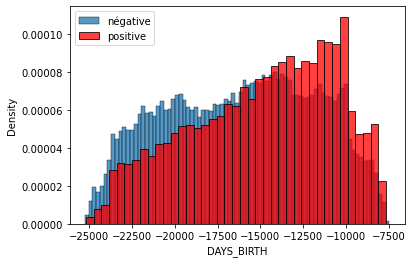

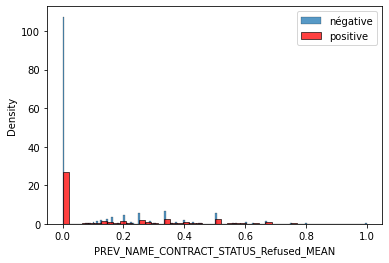

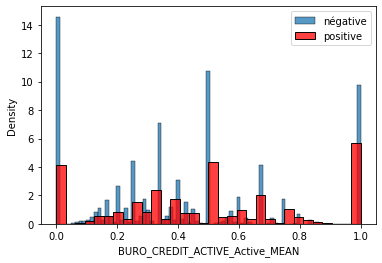

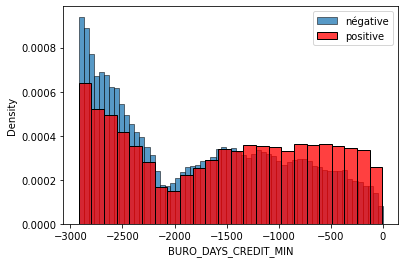

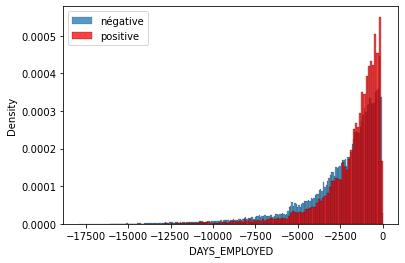

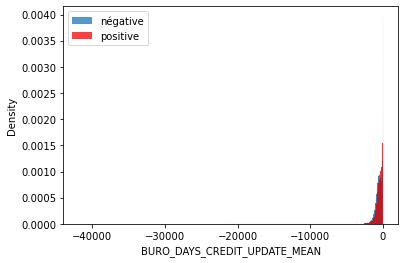

In [27]:
for col in columns :
    plt.figure()    
    sns.histplot(negative_df[col], label = 'négative', stat='density')
    sns.histplot(positive_df[col], label = 'positive', color='r',stat='density')
    plt.legend()

# Traitement des valeurs manquantes

In [15]:
train_missing = (train_df.isnull().sum() / len(train_df)).sort_values(ascending = False)
train_missing

BURO_AMT_ANNUITY_MEAN                                        0.739814
BURO_AMT_ANNUITY_MAX                                         0.739814
CC_AMT_DRAWINGS_CURRENT_VAR                                  0.719444
CC_CNT_DRAWINGS_CURRENT_VAR                                  0.719444
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR                             0.719444
CC_AMT_BALANCE_VAR                                           0.719444
CC_AMT_BALANCE_SUM                                           0.717389
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN                            0.717389
CC_CNT_DRAWINGS_CURRENT_MEAN                                 0.717389
CC_AMT_DRAWINGS_CURRENT_MEAN                                 0.717389
CC_AMT_BALANCE_MAX                                           0.717389
CC_CNT_INSTALMENT_MATURE_CUM_MAX                             0.717389
CC_AMT_BALANCE_MIN                                           0.717389
CC_MONTHS_BALANCE_MIN                                        0.717389
CC_AMT_DRAWINGS_ATM_

# SelectKBest

In [ ]:
train_df = pd.read_csv('data/traited/df_train_99.csv')

In [ ]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
x_train = train_df.loc[:, train_df.columns!='TARGET']
y_train = train_df.loc[:, train_df.columns=='TARGET']

In [ ]:
print(x_train.shape)
print(y_train.shape)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
select_feature = SelectKBest(chi2, k=50).fit(x_train, y_train)